In [58]:
import os
import sys
from sklearn.metrics import confusion_matrix

sys.path.append("../src")
from ridge_regression import *
from setup_problem import *


# Problem 2 Ridge Regression

### Problem 2.1

In [2]:
lasso_fname = os.path.join('..','src','lasso_data.pickle')

x_train, y_train, x_val, y_val, target_fn, coefs_true, featurize = load_problem(lasso_fname)

In [3]:
x_train_feat = featurize(x_train)
x_val_feat = featurize(x_val)

In [4]:
grid, df = do_grid_search_ridge(x_train_feat, y_train, x_val_feat, y_val)

In [5]:
df.head()

,param_l2reg,mean_test_score,mean_train_score
0,0.000001,0.172579,0.006752
1,0.000002,0.172566,0.006752
2,0.000004,0.172541,0.006752
3,0.000008,0.172490,0.006752
4,0.000016,0.172390,0.006752


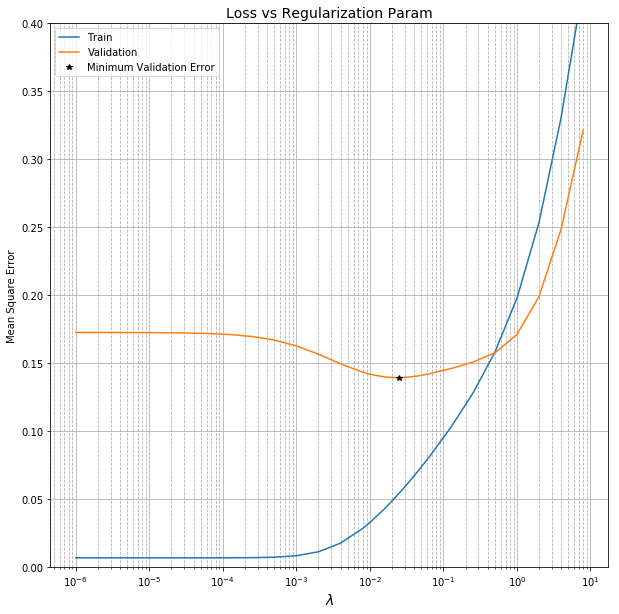

In [26]:
plt.figure(figsize=(10,10));

plt.semilogx(df.param_l2reg, df.mean_train_score, label='Train');
plt.semilogx(df.param_l2reg, df.mean_test_score, label='Validation');

min_index = df.mean_test_score.idxmin()
arg_min_lambda = df.param_l2reg[min_index]
min_test_score = df.mean_test_score[min_index]
plt.plot(arg_min_lambda, min_test_score, 'k*', label='Minimum Validation Error')

plt.title('Loss vs Regularization Param', fontsize=14);
plt.xlabel(r'$\lambda$', fontsize=14);
plt.ylabel('Mean Square Error');
plt.grid(b=True, which='major');
plt.grid(b=True, which='minor', linestyle='--');
plt.legend();

plt.ylim([0,0.4]);

### Problem 2.2

In [32]:
pred_fns = []
x = np.sort(np.concatenate([np.arange(0,1,.0001), x_train]))
X = featurize(x)

name = 'Target Parameter Values (i.e. Bayes Optimal)'
pred_fns.append({'name':name, 'coefs':coefs_true, 'preds': target_fn(x) })

name = 'Ridge with L2Reg=0'
ridge_regression_estimator = RidgeRegression(l2reg=0)
ridge_regression_estimator.fit(x_train_feat, y_train)
pred_fns.append({'name':name,'coefs':ridge_regression_estimator.w_, 
                 'preds': ridge_regression_estimator.predict(X) })

name = 'Ridge with L2Reg={0:.4}'.format(arg_min_lambda)
ridge_regression_estimator = RidgeRegression(l2reg=arg_min_lambda)
ridge_regression_estimator.fit(x_train_feat, y_train)
pred_fns.append({'name':name,'coefs':ridge_regression_estimator.w_, 
                 'preds': ridge_regression_estimator.predict(X)})

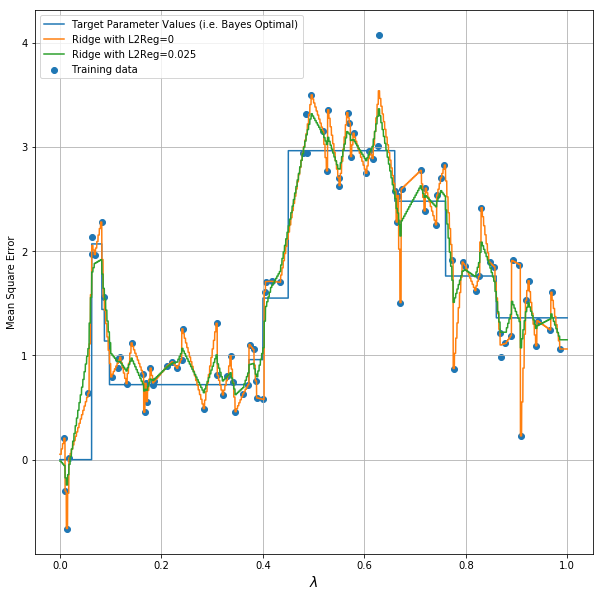

In [33]:
plt.figure(figsize=(10,10));
plt.scatter(x_train, y_train, label='Training data');

for i in range(len(pred_fns)):
    plt.plot(x, pred_fns[i]['preds'], label=pred_fns[i]['name']);
    
plt.legend();
plt.xlabel(r'$\lambda$', fontsize=14);
plt.ylabel('Mean Square Error');
plt.grid(b=True, which='major');
plt.grid(b=True, which='minor', linestyle='--');

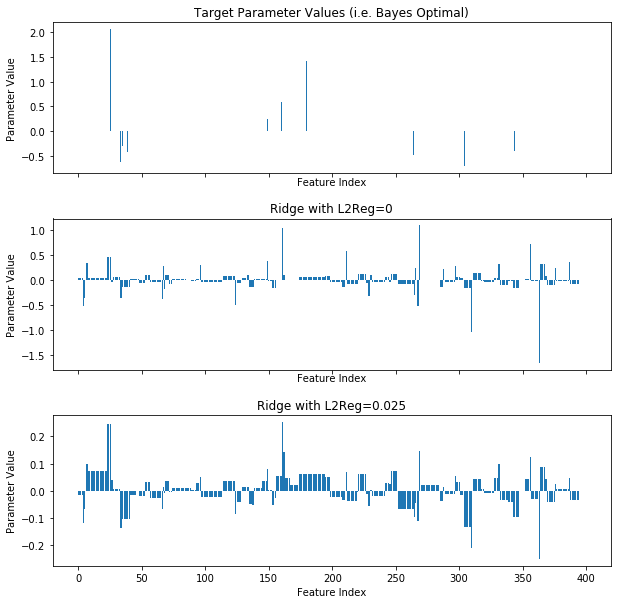

In [41]:
compare_parameter_vectors(pred_fns)

### Problem 2.3

In [51]:
ridge_regression_estimator = RidgeRegression(l2reg=arg_min_lambda)
ridge_regression_estimator.fit(x_train_feat, y_train)
best_coefs = ridge_regression_estimator.w_

In [52]:
y_true = coefs_true.copy()
y_true[np.abs(y_true) > 1e-6] = 1

In [62]:
y_1 = best_coefs.copy()
y_1[np.abs(y_1) > 1e-6] = 1
y_1[np.abs(y_1) <= 1e-6] = 0

y_2 = best_coefs.copy()
y_2[np.abs(y_2) > 1e-3] = 1
y_2[np.abs(y_2) <= 1e-3] = 0

y_3 = best_coefs.copy()
y_3[np.abs(y_3) > 1e-1] = 1
y_3[np.abs(y_3) <= 1e-1] = 0


In [63]:
confusion_matrix(y_true, y_1)

array([[  5, 385],
       [  0,  10]])

In [64]:
confusion_matrix(y_true, y_2)

array([[ 11, 379],
       [  0,  10]])

In [65]:
confusion_matrix(y_true, y_3)

array([[369,  21],
       [  5,   5]])

# Problem 3 Coordinate Descent for LASSO

### Problem 3.1 Shooting Algo

### Problem 3.2 Coordinate Minimizer Derivation

# Problem 4 LASSO Properties

The objective for LASSO problem without a bias term is 
$$J(w) = ||Xw - y||^2_2 + \lambda ||w||_1$$

### Problem 4.1 Deriving $\lambda_{max}$

The directional derivative in a direction $v$ at point $x$ is defined as 
$$ D_vf(x) = \lim_{\epsilon \rightarrow 0} \frac{f(x+\epsilon v) - f(x)}{\epsilon}$$

We want to find how large $\lambda$ should be to guarantee that all parameters are set to 0. To start, we compute the directional derivative at 0 of the lasso objective as $\epsilon$ approaches 0 from the right 

$$
\begin{align*}
D_vJ(0) &= \lim_{\epsilon \rightarrow 0^+} \frac{J(\epsilon v) - J(0)}{\epsilon}\\
&= \lim_{\epsilon \rightarrow 0^+} \frac{||\epsilon Xv -y||^2+ \lambda||\epsilon v||_1 - ||-y||^2}{\epsilon}\\
&= \lim_{\epsilon \rightarrow 0^+}\frac{\epsilon^2 ||Xv||^2 + ||y||^2 - 2\epsilon y^TXv+ \epsilon\lambda|| v||_1 - ||y||^2}{\epsilon}\\
&= \lim_{\epsilon \rightarrow 0^+} \epsilon ||Xv||^2  - 2y^TXv+ \lambda || v||_1\\
&= - 2y^TXv+ \lambda || v||_1\\
\end{align*}
$$

Since the LASSO objective is convex, we are guaranteed to be at a minimum if and only if the directional derivative is nonnegative for all directions $v$. Specifically, it means the function is increasing (or at least not decreasing) everywhere when we are at a minimum. 

Setting this inequality we find a condition on $\lambda$ guaranteeing a minimum

$$\begin{align*}
D_vJ(0) &\ge 0\\
-2y^TXv + \lambda||v||_1 &\ge 0\\
\lambda &\ge \frac{2y^TXv}{||v||_1}
\end{align*}
$$

The above choice of $\lambda$ is dependent on the direction $v$. To ensure the condition holds for any direction $v$ we solve the optimization problem 

$$\text{maximize}_v\quad \frac{2y^TXv}{||v||_1}$$
Writing out the objective we have the equivalent problem 
$$\text{maximize}_v\quad \sum_{i=1}^n \alpha_i \cdot \frac{v_i}{\sum_{j=1}^n |v_j|}$$

where $\alpha = 2X^Ty$. The solution of this optimization is $v^{\star} = \mathbf{sign}(v_k) \cdot e_k$ where $k = \arg \max_i |v_i|$ which achieves an optimal objective value of $||\alpha||_\infty$. Suppose we were to choose a vector different from $v^\star$, then we can always increase the objective by moving weight from any nonzero component $v_j$ to $v_k$.

So we find that choosing regularization strength $\lambda \ge 2||X^Ty||_\infty$ in the LASSO objective will always result in $w^\star = 0$

Now suppose we include the bias term so the objective is 
$$J (w, b) = ||Xw +b \mathbf{1} - y||^2 + \lambda ||w||_1$$

We proceed similar to the case without a bias term by finding the directional derivative and then a condition on $\lambda$ ensuring $w^\star =0$ and $b^\star = \bar{y}$.

$$
\begin{align*}
D_{[v^T, u]^T}J(0,\bar{y}) &= \lim_{\epsilon \rightarrow 0^+} \frac{J(\epsilon v, \bar{y}+\epsilon u) - J(0,\bar{y})}{\epsilon}\\
&= \lim_{\epsilon \rightarrow 0^+} \frac{||\epsilon Xv + (\bar{y}+\epsilon u) \mathbf{1}-y||^2+ \lambda||\epsilon v||_1 - ||\bar{y}\mathbf{1}-y||^2}{\epsilon}\\
&= \lim_{\epsilon \rightarrow 0^+} \frac{||(\epsilon Xv +\epsilon u \mathbf{1}) + (\bar{y}\mathbf{1}-y)||^2+ \lambda||\epsilon v||_1 - ||\bar{y}\mathbf{1}-y||^2}{\epsilon}\\
&= \lim_{\epsilon \rightarrow 0^+}\frac{||\epsilon Xv +  \epsilon u \mathbf{1}||^2  + ||\bar{y}\mathbf{1}-y||^2+2 (\bar{y}\mathbf{1}-y)^T(\epsilon Xv + \epsilon u \mathbf{1})+ \epsilon\lambda|| v||_1 - ||\bar{y}\mathbf{1}-y||^2}{\epsilon}\\
&= \lim_{\epsilon \rightarrow 0^+} \epsilon || Xv + u \mathbf{1}||^2 + 2(\bar{y}\mathbf{1}-y)^T( Xv + u \mathbf{1})+ \lambda || v||_1\\
&= 2(\bar{y}\mathbf{1}-y)^T( Xv + u \mathbf{1})+ \lambda || v||_1\\
\end{align*}
$$

Setting the directional derivative to be greater or equal to 0 we find
$$\begin{align*}
\lambda &\ge 2\cdot \frac{(y-\bar{y}\mathbf{1})^T( Xv + u \mathbf{1})}{||v||_1}\\
&=2\cdot \frac{(y-\bar{y}\mathbf{1})^TXv + u (y-\bar{y}\mathbf{1})^T\mathbf{1}}{||v||_1}\\
&=2\cdot \frac{(y-\bar{y}\mathbf{1})^TXv}{||v||_1}
\end{align*}
$$
where the last line comes from $(y-\bar{y}\mathbf{1})^T\mathbf{1} = y^T\mathbf{1} - \bar{y}n = 0$. To ensure $\lambda$ is large enough in all directions $[v,u]$ we maximize $2\cdot \frac{(y-\bar{y}\mathbf{1})^TXv}{||v||_1}$ which from the previous problem we know is 
$$\lambda_{max} = 2||X^T(y-\bar{y})||_\infty$$

### Problem 4.2 Feature Correlation

# Problem 5

Define the empirical least squares risk as 
$$
\begin{align*}
\hat{R}(w) &= \frac{1}{n}\sum_{i=1}^n (w^Tx_i - y_i)^2\\
        &= \frac{1}{n}(Xw - y)^T(Xw-y)
\end{align*}
$$
where $X\in \mathbf{R}^{n\times m}$ and $y\in \mathbf{R}^n$

### Problem 5.1

From the normal equations, the minimizer of $\hat{R}(w)$ is given by $\hat{w} = (X^TX)^{-1}X^Ty$. Plugging back into the objective we can find the minimum empirical risk

$$
\begin{align*}
\hat{R}(\hat{w}) &= \frac{1}{n}(X\hat{w} - y)^T(X\hat{w}-y)\\
&=\frac{1}{n}(\hat{w}^TX^TX\hat{w} - 2y^TX\hat{w} + y^Ty)\\
&=\frac{1}{n}(y^TX(X^TX)^{-1}X^TX(X^TX)^{-1}X^Ty - 2y^TX(X^TX)^{-1}X^Ty + y^Ty)\\
&=\frac{1}{n}(y^TX(X^TX)^{-1}X^Ty - 2y^TX(X^TX)^{-1}X^Ty + y^Ty)\\
&=\frac{1}{n}(-y^TX(X^TX)^{-1}X^Ty + y^Ty)\\
&=\frac{1}{n}(-y^TX\hat{w} + y^Ty)\\
\end{align*}
$$

### Problem 5.2

We can complete the square to rewrite the empirical risk in terms of its minimizer. Given a positive definite quadratic form $f(x) = x^TAx + b^Tx$ we can complete the square to get the equivalent form 
$$f(x) =(x + 0.5 A^{-1}b)^TA(x + 0.5 A^{-1}b) - \frac{1}{4}b^TA^{-1}b$$

Note that in the case of the empirical risk $A= X^TX$ and $b = -2X^Ty$

$$
\begin{align*}
\hat{R}(w) &=\frac{1}{n}\left(\hat{w}^TX^TX\hat{w} - 2y^TX\hat{w} + y^Ty\right)\\
&= \frac{1}{n}\left((w - ((X^TX)^{-1})(X^Ty))^T X^TX(w - ((X^TX)^{-1})(X^Ty)) - (X^Ty)^T(X^TX)^{-1}(X^Ty) + y^Ty\right)\\
&= \frac{1}{n}\left((w - \hat{w})^T X^TX(w - \hat{w}) - (X^Ty)^T\hat{w} + y^Ty\right)\\
&= \frac{1}{n}(w - \hat{w})^T X^TX(w - \hat{w}) + \hat{R}(\hat{w})\\
\end{align*}
$$

### Problem 5.3

Though we know $\hat{w}$ is the empirical risk minimizer based on the normal equations, it immediately follows from the completed square form in the previous part. Since $X^TX\succeq 0$ and $\hat{R}(\hat{w})$ is constant wrt $w$ then must choose $w = \hat{w}$ to achieve a value of zero for the first term which is the lowest it can be. Therefore,

$$\hat{w} = \arg \min_w \hat{R}(w)$$

### Problem 5.4

Consider the level sets of $\hat{R}(w)$ which are given by 

$$
\begin{align*}
\frac{1}{n}(w - \hat{w})^T X^TX(w - \hat{w}) + \hat{R}(\hat{w}) = c\\
\implies \frac{1}{n (c - \hat{R}(\hat{w}))}(w - \hat{w})^T X^TX(w - \hat{w}) = 1\\
\end{align*}
$$

This is the definition of an ellipse centered at $\hat{w}$